##### Copyright 2018 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 階乗混合

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/probability/examples/Factorial_Mixture"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Factorial_Mixture.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/probability/examples/Factorial_Mixture.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/probability/examples/Factorial_Mixture.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このノートブックでは、[TensorFlow Probability](https://github.com/tensorflow/probability)（TFP）を使用して、次のように定義されるガウス分布の階乗混合からサンプルを取得する方法を説明します。$$p(x_1, ..., x_n) = \prod_i p_i(x_i)$$ where: $$\begin{align*} p_i &amp;\equiv \frac{1}{K}\sum_{k=1}^K \pi_{ik},\text{Normal}\left(\text{loc}=\mu_{ik},, \text{scale}=\sigma_{ik}\right)\1&amp;=\sum_{k=1}^K\pi_{ik}, \forall i.\hphantom{MMMMMMMMMMM}\end{align*}$$

それぞれの変数 $x_i$ はガウス分布の混合としてモデル化されており、すべての $n$ 変数に対する同時分布はこれらの密度の積です。

データセット $x^{(1)}, ..., x^{(T)}$ がある場合、各データポイント $x^{(j)}$ をガウス分布の階乗混合としてモデル化します: $$p(x^{(j)}) = \prod_i p_i (x_i^{(j)})$$

階乗混合は、少数のパラメータと大量のモードで分布を作成する単純な方法です。

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

# Use try/except so we can easily re-execute the whole notebook.
try:
  tf.enable_eager_execution()
except:
  pass

## TFP を使ってガウス分布の階乗混合を構築する

In [ ]:
num_vars = 2        # Number of variables (`n` in formula).
var_dim = 1         # Dimensionality of each variable `x[i]`.
num_components = 3  # Number of components for each mixture (`K` in formula).
sigma = 5e-2        # Fixed standard deviation of each component.

# Choose some random (component) modes.
component_mean = tfd.Uniform().sample([num_vars, num_components, var_dim])

factorial_mog = tfd.Independent(
   tfd.MixtureSameFamily(
       # Assume uniform weight on each component.
       mixture_distribution=tfd.Categorical(
           logits=tf.zeros([num_vars, num_components])),
       components_distribution=tfd.MultivariateNormalDiag(
           loc=component_mean, scale_diag=[sigma])),
   reinterpreted_batch_ndims=1)

`tfd.Independent` を使用しているところに注意してください。この「meta-distribution」は `reduce_sum` を、右端の `reinterpreted_batch_ndims` バッチ次元に対して `log_prob` に適用します。この場合、これは `log_prob` を計算するときに、バッチ次元のみを残して変数次元を合計します。これによるサンプリングへの影響はありません。

## 密度をプロットする

ポイントのグリッドで密度を計算し、モードの場所を赤い星印で示します。階乗混合の各モードは、根底にあるガウス分布の個体変数混合のモードのペアに対応しています。以下のプロットには 9 つのモードがありますが、必要なのは 6 つのパラメータのみです（$x_1$ のモードの場所を指定する 3 つのパラメータと、$x_2$ のモードの場所を指定する 3 つのパラメータ）。逆に、2 次空間のガウス分布の混合には、9 つのモードを指定するために、2 * 9 = 18 個のパラメータが必要となります。

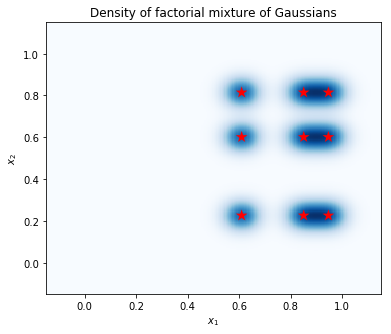

In [7]:
plt.figure(figsize=(6,5))

# Compute density.
nx = 250 # Number of bins per dimension.
x = np.linspace(-3 * sigma, 1 + 3 * sigma, nx).astype('float32')
vals = tf.reshape(tf.stack(np.meshgrid(x, x), axis=2), (-1, num_vars, var_dim))
probs = factorial_mog.prob(vals).numpy().reshape(nx, nx)

# Display as image.
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("Blues", 256))
p = plt.pcolor(x, x, probs, cmap=cmap)
ax = plt.axis('tight');

# Plot locations of means.
means_np = component_mean.numpy().squeeze()
for mu_x in means_np[0]:
  for mu_y in means_np[1]:
    plt.scatter(mu_x, mu_y, s=150, marker='*', c='r', edgecolor='none');
plt.axis(ax);

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Density of factorial mixture of Gaussians');

## サンプルと周辺密度の推定をプロットする

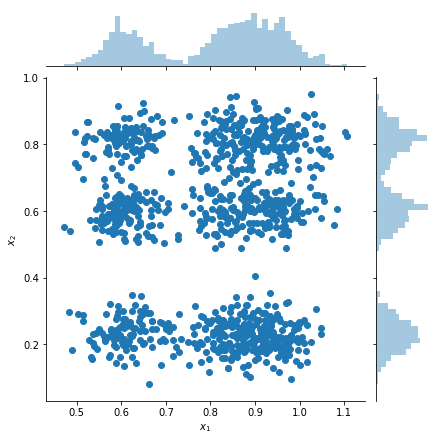

In [8]:
samples = factorial_mog.sample(1000).numpy()

g = sns.jointplot(
    x=samples[:, 0, 0],
    y=samples[:, 1, 0],
    kind="scatter",
    marginal_kws=dict(bins=50))
g.set_axis_labels("$x_1$", "$x_2$");